In [1]:
import xarray as xr
import numpy as np
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling
from isca_tools.utils import print_ds_var_list
import cftime
import matplotlib.pyplot as plt

In [3]:
exp_name = 'e.e20.E1850TEST.f09_g17.test'
var_keep = ['TS', 'FSNTOA', 'FLNT', 'gw', 'T']
ds = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, months_keep=[6])[var_keep].load()

In [3]:
exp_name = 'e.e20.ETEST.f19_g17.test_daily_output'
var_keep = ['TS', 'FSNTOA', 'FLNT', 'gw', 'T']
ds = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, months_keep=[1]).load()
ds_daily = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1).load()
ds_lnd_daily = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1, comp='lnd').load()

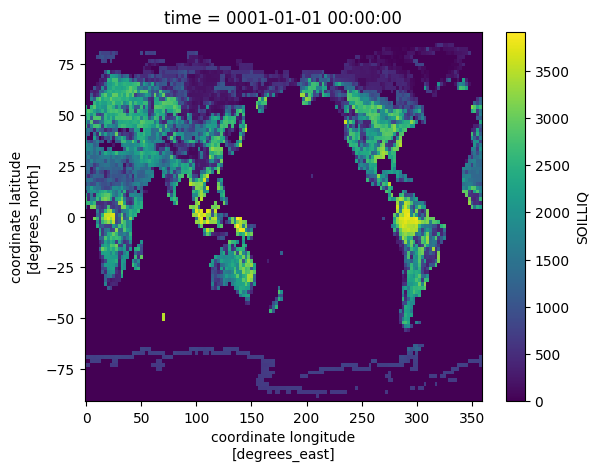

In [9]:
ds_lnd_daily.SOILLIQ.isel(time=0).sum(dim='levsoi').plot()

In [91]:
ds_lnd = cesm.load_dataset(exp_name, comp='lnd', archive_dir=cesm.local_archive_dir, months_keep=[1])

In [95]:
print_ds_var_list(ds_lnd, 'TV')

TV: vegetation temperature


In [88]:
ds_lnd = ds_lnd[['SOILLIQ']].load()

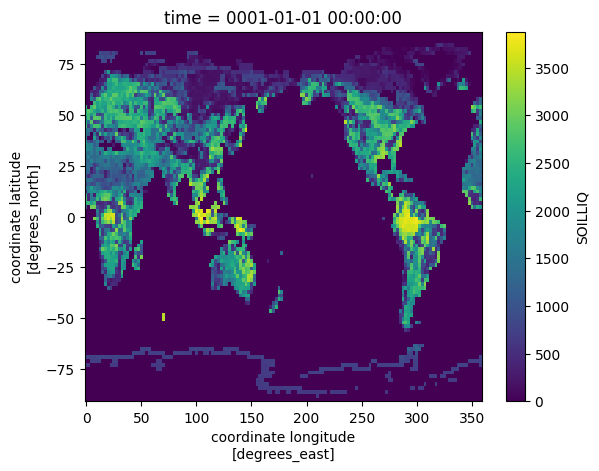

In [83]:
ds_lnd['SOILLIQ'].load().sum(dim='levsoi').plot()

In [5]:
ds_daily = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1)

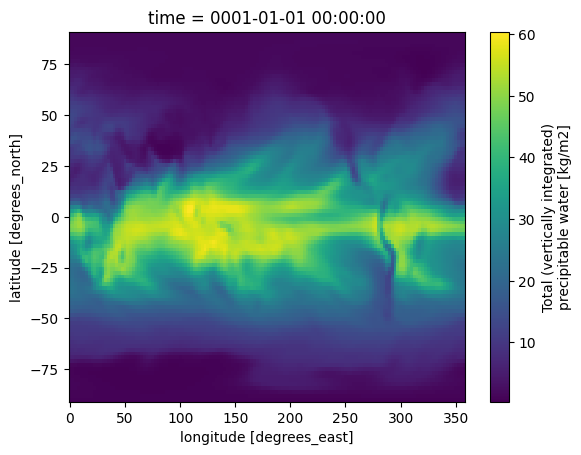

In [16]:
ds.TMQ.plot()

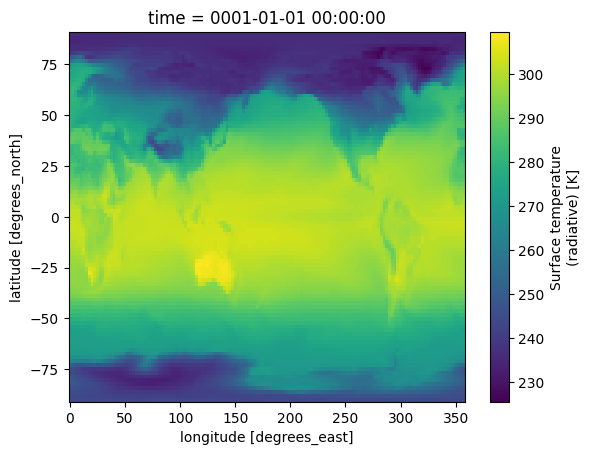

In [36]:
ds.TS.plot()

In [31]:
ds.U10

<xarray.DataArray 'U10' (time: 1, lat: 192, lon: 288)> Size: 221kB
array([[[5.6898546, 5.6898546, 5.6898546, ..., 5.6898546, 5.6898546,
         5.6898546],
        [6.21897  , 6.208599 , 6.2006717, ..., 6.25234  , 6.2412376,
         6.229883 ],
        [7.1094933, 7.100881 , 7.0887938, ..., 7.1213026, 7.1189976,
         7.114927 ],
        ...,
        [4.6538386, 4.671346 , 4.6899805, ..., 4.6129107, 4.6258473,
         4.6391115],
        [4.775083 , 4.7824636, 4.790222 , ..., 4.7521586, 4.760174 ,
         4.7677054],
        [4.8478875, 4.84818  , 4.8484497, ..., 4.8468375, 4.84722  ,
         4.8475685]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 8B 0030-06-01 00:00:00
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

In [32]:
print_ds_var_list(ds, 'net')

FLNS: Net longwave flux at surface
FLNSC: Clearsky net longwave flux at surface
FLNT: Net longwave flux at top of model
FLNTC: Clearsky net longwave flux at top of model
FLNTCLR: Clearsky ONLY points net longwave flux at top of model
FSNS: Net solar flux at surface
FSNSC: Clearsky net solar flux at surface
FSNT: Net solar flux at top of model
FSNTC: Clearsky net solar flux at top of model
FSNTOA: Net solar flux at top of atmosphere
FSNTOAC: Clearsky net solar flux at top of atmosphere


In [3]:
window_lon = 3
window_lat = 3
ds_av = lat_lon_rolling(ds, window_lat, window_lon)

In [63]:
ds.TS.lon

<xarray.DataArray 'lon' (lon: 288)> Size: 2kB
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  longitude
    units:      degrees_east

In [179]:
# First month is marked as February not January, need to change
n_day_month = np.asarray([cftime.DatetimeNoLeap(1, i+1, 1).daysinmonth for i in range(12)])         # number of days in each month
n_months_in_ds = ds.time.size
n_years_in_ds = int(np.floor(n_months_in_ds/12))
month_shift_array = np.concatenate((np.tile(n_day_month, n_years_in_ds), n_day_month[:n_months_in_ds%12]))
ds=ds.assign_coords({'time':('time',ds.time.values-month_shift_array,ds.time.attrs)})

In [182]:
ds = xr.decode_cf(ds)

## Plot global mean Surface Temperature

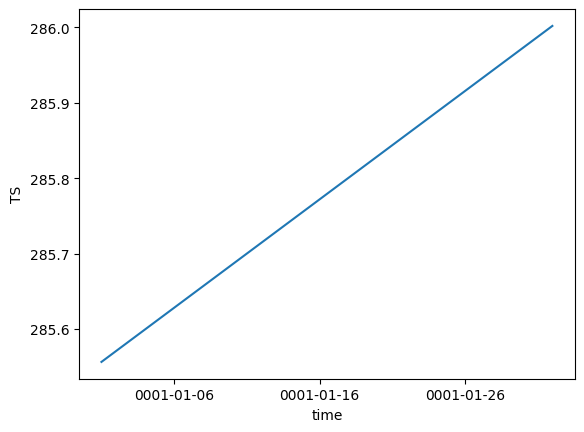

In [185]:
area_weighting(ds.TS).mean(dim=['lat', 'lon']).plot()

## Plot global mean TOA flux inbalance

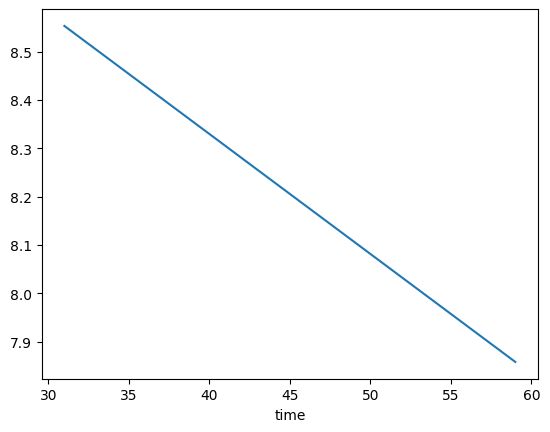

In [55]:
area_weighting(ds.FSNTOA-ds.FLNT).mean(dim=['lon', 'lat']).plot()

In [31]:
weight_factor = {'cos_lat': np.cos(np.deg2rad(ds.lat)), 'gw': ds.gw.isel(time=1, drop=True)}
for var in weight_factor:
    weight_factor[var] = weight_factor[var] / weight_factor[var].mean()

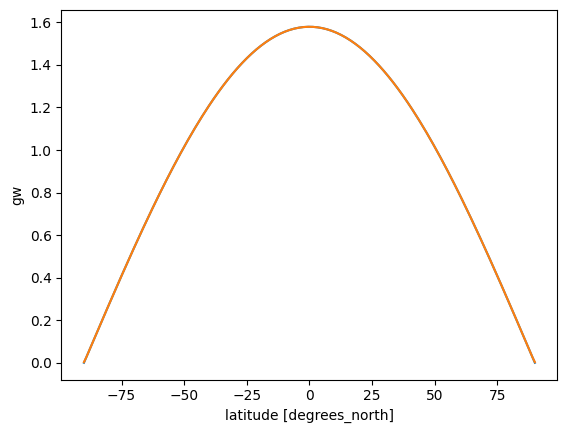

In [34]:
weight_factor['cos_lat'].plot()
weight_factor['gw'].plot()

Text(0, 0.5, 'weight_cos_lat - weight_gw')

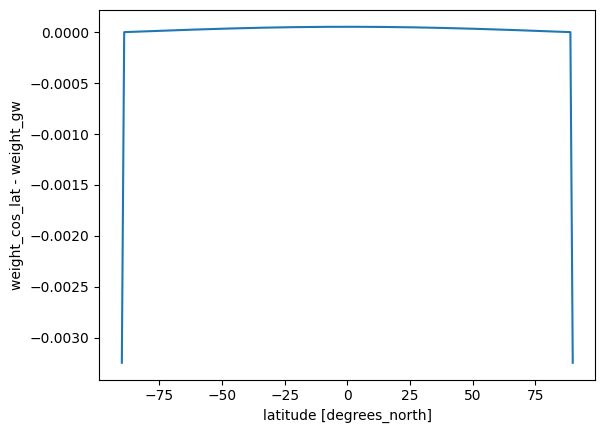

In [44]:
(weight_factor['cos_lat'] - weight_factor['gw']).plot()
plt.ylabel('weight_cos_lat - weight_gw')

In [54]:
weight_factor['gw'].to_numpy()

array([0.00324647, 0.02597047, 0.05193391, 0.0778833 , 0.10381162,
       0.12971186, 0.155577  , 0.18140006, 0.20717404, 0.23289197,
       0.2585469 , 0.28413188, 0.30964   , 0.33506434, 0.36039804,
       0.38563424, 0.41076611, 0.43578686, 0.46068971, 0.48546793,
       0.51011481, 0.53462368, 0.55898793, 0.58320094, 0.60725619,
       0.63114714, 0.65486735, 0.6784104 , 0.70176991, 0.72493957,
       0.7479131 , 0.7706843 , 0.79324701, 0.81559511, 0.83772257,
       0.85962339, 0.88129165, 0.9027215 , 0.92390712, 0.9448428 ,
       0.96552287, 0.98594172, 1.00609385, 1.02597379, 1.04557617,
       1.06489569, 1.08392711, 1.10266529, 1.12110517, 1.13924174,
       1.15707012, 1.17458546, 1.19178304, 1.2086582 , 1.22520637,
       1.24142309, 1.25730395, 1.27284467, 1.28804105, 1.30288896,
       1.31738439, 1.33152343, 1.34530224, 1.35871711, 1.37176439,
       1.38444056, 1.39674219, 1.40866596, 1.42020863, 1.43136709,
       1.44213831, 1.45251938, 1.4625075 , 1.47209995, 1.48129

In [52]:
weight_factor['cos_lat']

<xarray.DataArray 'lat' (lat: 192)> Size: 2kB
array([9.66892933e-17, 2.59713457e-02, 5.19356652e-02, 7.78859343e-02,
       1.03815133e-01, 1.29716245e-01, 1.55582265e-01, 1.81406195e-01,
       2.07181047e-01, 2.32899850e-01, 2.58555646e-01, 2.84141493e-01,
       3.09650470e-01, 3.35075676e-01, 3.60410232e-01, 3.85647285e-01,
       4.10780006e-01, 4.35801598e-01, 4.60705289e-01, 4.85484344e-01,
       5.10132059e-01, 5.34641765e-01, 5.59006832e-01, 5.83220668e-01,
       6.07276722e-01, 6.31168487e-01, 6.54889499e-01, 6.78433340e-01,
       7.01793642e-01, 7.24964084e-01, 7.47938397e-01, 7.70710368e-01,
       7.93273834e-01, 8.15622692e-01, 8.37750896e-01, 8.59652459e-01,
       8.81321456e-01, 9.02752025e-01, 9.23938368e-01, 9.44874754e-01,
       9.65555518e-01, 9.85975065e-01, 1.00612787e+00, 1.02600849e+00,
       1.04561153e+00, 1.06493170e+00, 1.08396377e+00, 1.10270258e+00,
       1.12114308e+00, 1.13928027e+00, 1.15710925e+00, 1.17462518e+00,
       1.19182334e+00, 1.20869907e+00, 1.22524781e+00, 1.24146507e+00,
       1.25734647e+00, 1.27288772e+00, 1.28808461e+00, 1.30293302e+00,
       1.31742895e+00, 1.33156846e+00, 1.34534774e+00, 1.35876306e+00,
       1.37181078e+00, 1.38448738e+00, 1.39678943e+00, 1.40871360e+00,
       1.42025666e+00, 1.43141549e+00, 1.44218708e+00, 1.45256850e+00,
       1.46255696e+00, 1.47214974e+00, 1.48134425e+00, 1.49013801e+00,
       1.49852863e+00, 1.50651385e+00, 1.51409150e+00, 1.52125954e+00,
...
       1.52125954e+00, 1.51409150e+00, 1.50651385e+00, 1.49852863e+00,
       1.49013801e+00, 1.48134425e+00, 1.47214974e+00, 1.46255696e+00,
       1.45256850e+00, 1.44218708e+00, 1.43141549e+00, 1.42025666e+00,
       1.40871360e+00, 1.39678943e+00, 1.38448738e+00, 1.37181078e+00,
       1.35876306e+00, 1.34534774e+00, 1.33156846e+00, 1.31742895e+00,
       1.30293302e+00, 1.28808461e+00, 1.27288772e+00, 1.25734647e+00,
       1.24146507e+00, 1.22524781e+00, 1.20869907e+00, 1.19182334e+00,
       1.17462518e+00, 1.15710925e+00, 1.13928027e+00, 1.12114308e+00,
       1.10270258e+00, 1.08396377e+00, 1.06493170e+00, 1.04561153e+00,
       1.02600849e+00, 1.00612787e+00, 9.85975065e-01, 9.65555518e-01,
       9.44874754e-01, 9.23938368e-01, 9.02752025e-01, 8.81321456e-01,
       8.59652459e-01, 8.37750896e-01, 8.15622692e-01, 7.93273834e-01,
       7.70710368e-01, 7.47938397e-01, 7.24964084e-01, 7.01793642e-01,
       6.78433340e-01, 6.54889499e-01, 6.31168487e-01, 6.07276722e-01,
       5.83220668e-01, 5.59006832e-01, 5.34641765e-01, 5.10132059e-01,
       4.85484344e-01, 4.60705289e-01, 4.35801598e-01, 4.10780006e-01,
       3.85647285e-01, 3.60410232e-01, 3.35075676e-01, 3.09650470e-01,
       2.84141493e-01, 2.58555646e-01, 2.32899850e-01, 2.07181047e-01,
       1.81406195e-01, 1.55582265e-01, 1.29716245e-01, 1.03815133e-01,
       7.78859343e-02, 5.19356652e-02, 2.59713457e-02, 9.66892933e-17])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0

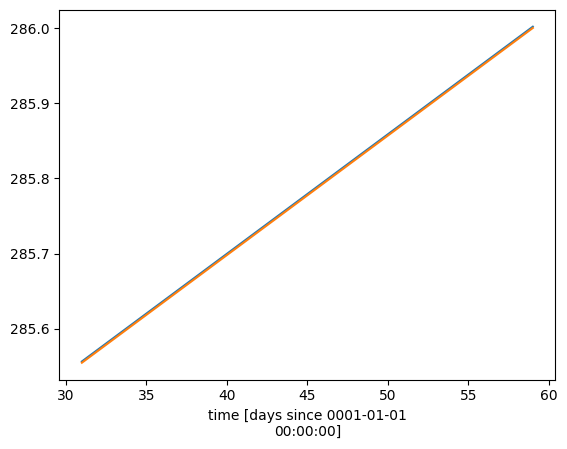

In [40]:
area_weighting(ds.TS).mean(dim=['lat', 'lon']).plot()
# (ds.TS*weight_factor['cos_lat']).mean(dim=['lat', 'lon']).plot()
(ds.TS*weight_factor['gw']).mean(dim=['lat', 'lon']).plot()